# Camera Calibration

This experiment will load 11 calibration images and tries to estimate the intrinsic camera parameters. These parameters can then be used to correct the optical distortions in an image.

Also see https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

## Change working directory (can also be changed from terminal if working locally)

Change working directory to directory containing the notebook and images (e.g. is using Google Colab)

In [5]:
# Using Venv

In [6]:
use_GoogleColab = False # Set to True if using Google Colab
if use_GoogleColab:
  from google.colab.patches import cv2_imshow # Optional, if using Google Colab

## Load images and determine which are suitable for calibration

In [7]:
import glob

# Derive a list of all the calibration images to be considered
images = glob.glob('./Data/*.jpg')
images

['./Data/left03.jpg',
 './Data/left05.jpg',
 './Data/left06.jpg',
 './Data/left13.jpg',
 './Data/left14.jpg',
 './Data/left02.jpg',
 './Data/left12.jpg',
 './Data/left04.jpg',
 './Data/left01.jpg',
 './Data/left07.jpg',
 './Data/left08.jpg',
 './Data/left09.jpg',
 './Data/left11.jpg']

In [8]:
import numpy as np
import cv2 as cv

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001) 
# epsilon = 0.001, max_iter = 30

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Ngood = 0 is the number of images that are considered for calibration
Ngood = 0
# Loop through all the images
for fname in images:
    # Read the image
    img = cv.imread(fname)
    # Convert the image to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners, implemented in OpenCV
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        # Increment the number of images that are considered for calibration
        Ngood += 1
        # Print the image shape
        print('Image Shape: ({},{})'.format(img.shape[1], img.shape[0]))
        # Append the object points
        objpoints.append(objp)
        # Refine the corner locations
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria) # Find more exact corner locations (in subpixels)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        if use_GoogleColab:
          cv2_imshow(img)
        else:
          # Display the image
          cv.imshow('img', img)
        # Wait for 500 ms
        cv.waitKey(500)
# Close the window
cv.destroyAllWindows()

print('{} out of {} images are considered for calibration.'.format(Ngood, len(images)))

Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
Image Shape: (640,480)
10 out of 13 images are considered for calibration.


Use `calibrateCamera` to estimate the intrinsic parameters of the camera. These parameters belong to the specific camera considered.

The extrinsic parameters are more useful in applications such as stereo vision.

In [9]:
# Derive the camera calibration parameters
ret, K, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [10]:
# Print the intrinsic camera parameters K
print(K)

[[533.82282876   0.         341.13357999]
 [  0.         533.87400826 231.98840517]
 [  0.           0.           1.        ]]


In [11]:
# Print the vector of rotation vectors
rvecs

(array([[-0.26588156],
        [-0.3957271 ],
        [-2.74739469]]),
 array([[-0.30115488],
        [ 0.39164629],
        [-1.43505581]]),
 array([[ 0.30508279],
        [ 0.50280266],
        [-1.82876491]]),
 array([[-0.17356648],
        [-0.46585024],
        [ 1.34795522]]),
 array([[ 0.41342695],
        [ 0.65611925],
        [-1.337996  ]]),
 array([[-0.24183643],
        [ 0.35510801],
        [ 1.53039945]]),
 array([[-0.37966513],
        [-0.18305795],
        [-3.11603634]]),
 array([[-0.4332026 ],
        [ 0.25348001],
        [-3.08864865]]),
 array([[-0.32238873],
        [ 0.15968428],
        [-1.24172213]]),
 array([[-0.46071021],
        [-0.0889093 ],
        [-1.33496028]]))

In [12]:
# Print the vector of translation vectors
tvecs

(array([[3.04424099],
        [2.76484983],
        [9.88809753]]),
 array([[ 1.61579383],
        [ 3.84186156],
        [16.10716183]]),
 array([[-1.21147846],
        [ 3.54947153],
        [15.66141149]]),
 array([[ 1.82877504],
        [-4.24173465],
        [12.45718574]]),
 array([[-2.11448917],
        [ 1.86835444],
        [12.80560801]]),
 array([[ 2.05861524],
        [-4.01659172],
        [12.84417706]]),
 array([[ 2.83164728],
        [ 2.24371524],
        [10.94667288]]),
 array([[ 3.80885384],
        [ 0.92598419],
        [14.84828451]]),
 array([[-5.92948006],
        [ 2.4271644 ],
        [16.77332979]]),
 array([[-3.2701155 ],
        [ 2.17933732],
        [11.72262508]]))

The result shows that the camera has a focal length of about 534 pixels.

The optical centers are roughly (341, 232) which are quite close to the center of the images (640/2=320, 480/2=240).

## Undistort an image

(np.float64(-0.5), np.float64(609.5), np.float64(431.5), np.float64(-0.5))

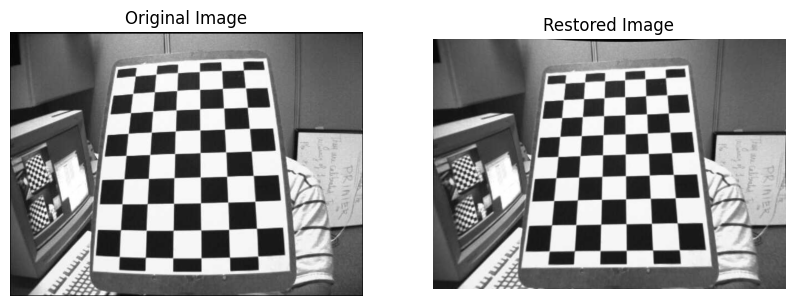

In [13]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

# Load the distorted image
img = cv.imread('./Data/left12.jpg')
h,  w = img.shape[:2]

# Compute the optimal camera matrix
K_new, roi = cv.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))

# undistort
img_restored = cv.undistort(img, K, dist, None, K_new)

# crop the image
x, y, w, h = roi
img_restored = img_restored[y:y+h, x:x+w]

import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_restored)
plt.title('Restored Image')
plt.axis('off')

What do you observe in the restored image? (Hint: look at the edges)